# MindSpore ConvGRU Falling Circle Demo

This notebook demonstrates the ConvGRU model processing a sequence of frames showing a falling circle animation.

In [1]:
import mindspore as ms
import mindspore.nn as nn
import mindspore.ops as ops
import numpy as np
import matplotlib.pyplot as plt
from mindspore import context
from mindspore_convgru import ConvGRU

# Set context and seeds for reproducibility
context.set_context(mode=context.PYNATIVE_MODE)
ms.set_seed(42)
np.random.seed(42)

## 1. Creating Sample Data - Falling Circle Animation

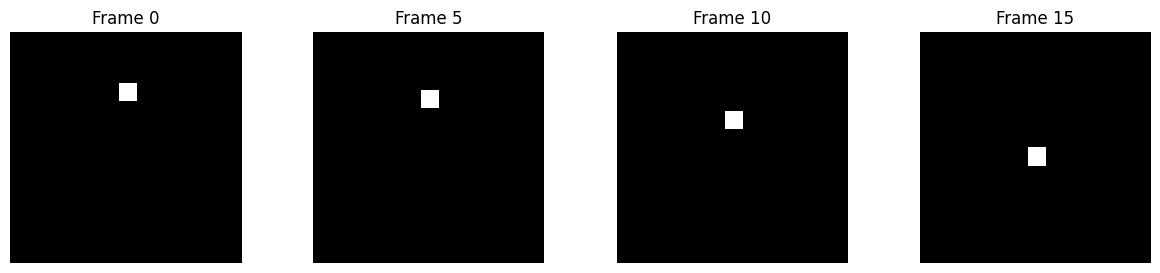

In [2]:
def create_falling_circle(frames=10, size=64, radius=3):
    """Create a sequence of frames with a falling circle."""
    sequence = np.zeros((frames, 1, size, size), dtype=np.float32)
    
    # Create coordinates grid
    x = np.linspace(0, size-1, size)
    y = np.linspace(0, size-1, size)
    xx, yy = np.meshgrid(x, y)
    
    # Initial position
    center_x = size // 2
    initial_y = size // 4
    
    for i in range(frames):
        # Update y position with acceleration (quadratic motion)
        t = i / frames
        center_y = initial_y + (size//2) * t * t  # Quadratic fall
        
        # Create circle
        circle = ((xx - center_x)**2 + (yy - center_y)**2) < radius**2
        sequence[i, 0] = circle.astype(np.float32)
    
    return sequence

# Create sample sequence
sequence = create_falling_circle(frames=20)  # More frames for smoother motion

# Display some frames
fig, axes = plt.subplots(1, 4, figsize=(15, 3))
for i, ax in enumerate(axes):
    frame_idx = i * 5  # Show evenly spaced frames
    ax.imshow(sequence[frame_idx, 0], cmap='gray')
    ax.axis('off')
    ax.set_title(f'Frame {frame_idx}')
plt.show()

## 2. Setting up the ConvGRU Model

In [3]:
# Model parameters
input_channels = 1
hidden_channels = [32, 64, 32]
kernel_sizes = [3, 5, 3]
n_layers = 3

# Create the model
model = ConvGRU(
    input_size=input_channels,
    hidden_sizes=hidden_channels,
    kernel_sizes=kernel_sizes,
    n_layers=n_layers
)

print("Model created successfully!")

Model created successfully!


## 3. Processing the Sequence with ConvGRU

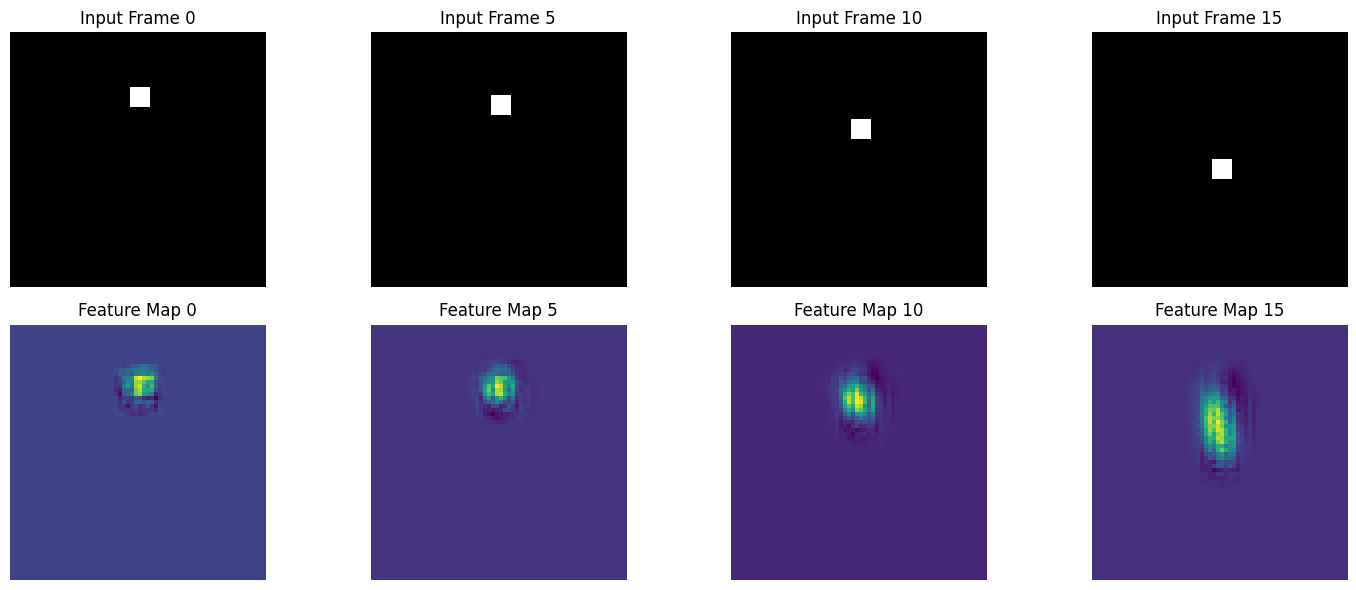

In [16]:
# Convert numpy array to MindSpore tensor
sequence_ms = ms.Tensor(sequence)

# Process each frame
outputs = []
hidden_states = None

for frame in sequence_ms:
    # Add batch dimension
    frame = ops.expand_dims(frame, 0)
    # Process frame and get hidden states
    hidden_states = model(frame, hidden_states)
    # Store output from last layer
    outputs.append(hidden_states[-1].asnumpy())

outputs = np.stack(outputs)

# Display input and output
fig, axes = plt.subplots(2, 4, figsize=(15, 6))
for i in range(4):
    frame_idx = i * 5  # Show evenly spaced frames
    
    # Display input
    axes[0, i].imshow(sequence[frame_idx, 0], cmap='gray')
    axes[0, i].axis('off')
    axes[0, i].set_title(f'Input Frame {frame_idx}')
    
    # Display output (first channel of last layer)
    axes[1, i].imshow(outputs[frame_idx, 0, 0], cmap='viridis')
    axes[1, i].axis('off')
    axes[1, i].set_title(f'Feature Map {frame_idx}')

plt.tight_layout()
plt.show()

## 4. Analyzing Model Response to Falling Motion

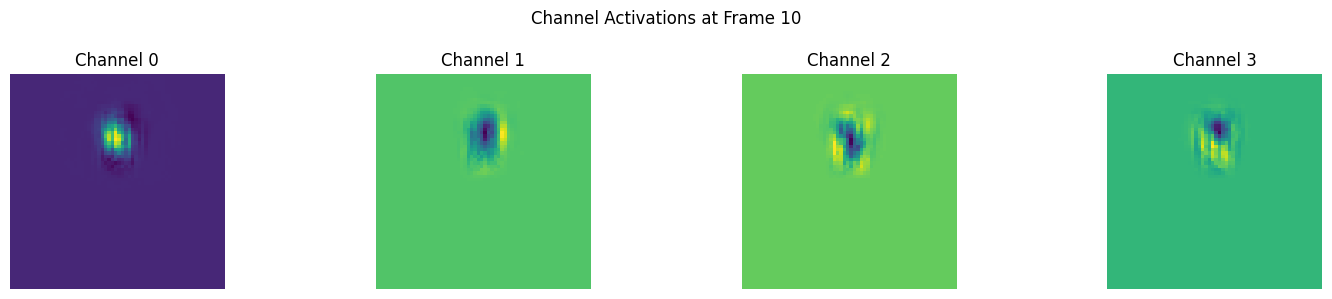


Model Analysis:
Number of layers: 3
Hidden channels per layer: [32, 64, 32]
Kernel sizes per layer: [3, 5, 3]

Output sequence shape: (20, 1, 32, 64, 64)


In [8]:
# Analyze activation patterns in different channels
def plot_channel_activations(frame_idx):
    """Plot activations from different channels for a specific frame."""
    n_channels = 4  # Number of channels to display
    fig, axes = plt.subplots(1, n_channels, figsize=(15, 3))
    
    for i in range(n_channels):
        axes[i].imshow(outputs[frame_idx, 0, i], cmap='viridis')
        axes[i].axis('off')
        axes[i].set_title(f'Channel {i}')
    
    plt.suptitle(f'Channel Activations at Frame {frame_idx}')
    plt.tight_layout()
    plt.show()

# Plot activations for a middle frame
plot_channel_activations(10)

# Print model statistics
print("\nModel Analysis:")
print(f"Number of layers: {n_layers}")
print(f"Hidden channels per layer: {hidden_channels}")
print(f"Kernel sizes per layer: {kernel_sizes}")
print(f"\nOutput sequence shape: {outputs.shape}")